In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import torchvision
from torchvision import transforms

In [2]:
torch.__version__

'2.1.0+cu118'

# 数据准备

In [3]:
# 对数据做归一化 （-1，1）
transform = transforms.Compose([
    transforms.ToTensor(),             # 0-1:channel,high,width
    transforms.Normalize(0.5, 0.5)  
])

In [4]:
train_ds = torchvision.datasets.MNIST('./data',
                                      train = True,
                                      transform = transform,
                                      download = True)

In [5]:
dataloader = torch.utils.data.DataLoader(train_ds, batch_size = 64, shuffle = True)

In [6]:
imgs, _ = next(iter(dataloader))

### [iter与numerate区别](https://blog.csdn.net/qq_43391414/article/details/118575559)

In [7]:
imgs.shape
# batch_size, img_size

torch.Size([64, 1, 28, 28])

# 定义生成器

In [8]:
# 输入是长度是100的噪声（正态随机分布）
# 输出为（1，28，28）的图片
#linear 1: 100--256
#linear 2: 256--512
#linear 3: 512--28*28
#reshape:  28*28--(1,28,28)
        

In [9]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(nn.Linear(100,256),
                                  nn.ReLU(),
                                  nn.Linear(256,512),
                                  nn.ReLU(),
                                  nn.Linear(512,28*28),
                                  nn.Tanh()
                                 )
    def forward(self, x):    # x表示长度为100的noise输入
        img = self.main(x)
        img = img.view(-1,28,28,1)
        return img

# 定义判别器

In [10]:
## 输入为（1，28，28）的图片 输出二分类的概率值，输出使用sigmoid激活0-1
# BCEloss计算交叉熵损失

#  nn.LeakyReLU() f(x):x>0 输出0，x<0,输出 a*x a表示一个很小的斜率，如0.1
# 判别器中一般推荐使用 LeakyReLU

In [11]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(nn.Linear(28*28,512),
                                  nn.LeakyReLU(),
                                  nn.Linear(512,256),
                                  nn.ReLU(),
                                  nn.Linear(256,1),
                                  nn.Sigmoid()
                                 )
    def forward(self, x):
        x = x.view(-1, 28*28)
        x = self.main(x)
        return x

In [12]:
# 初始化模型。优化器及损失函数
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [13]:
Gen = Generator().to(device)
Dis = Discriminator().to(device)

In [14]:
Doptim = torch.optim.Adam(Dis.parameters(), lr = 0.0001)
Goptim = torch.optim.Adam(Gen.parameters(), lr = 0.0001)

In [15]:
loss = torch.nn.BCELoss()

# 绘图函数

In [16]:
def Gen_img_plot(model, test_input):
    prediction = np.squeeze(model(test_input).detach().cpu().numpy()) 
    ### https://blog.csdn.net/weixin_38424903/article/details/107649436
    fig = plt.figure(figsize = (4,4))
    for i in range(16):
        plt.subplot(4,4,i+1)
        plt.imshow((prediction[i]+1)/2)
        plt.axis('off')
    plt.show()

In [17]:
test_input = torch.randn(16,100,device = device)

# GAN的训练

In [18]:
Dloss = []
Gloss = []

Epoch: 0


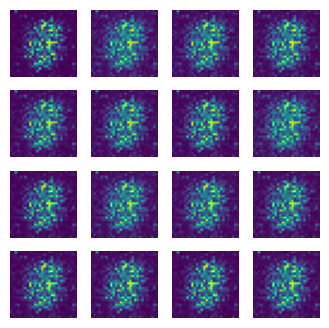

Epoch: 1


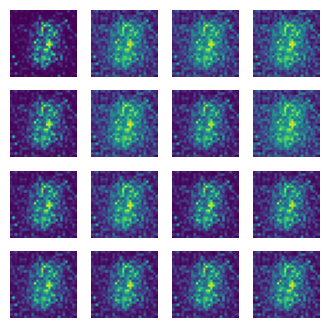

Epoch: 2


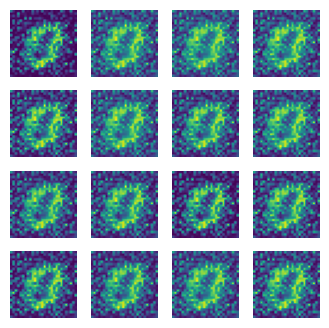

Epoch: 3


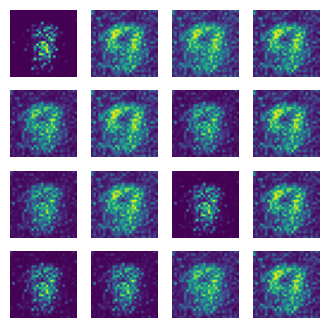

In [ ]:
# 训练循环
for epoch in range(50):
    Depoch_loss = 0
    Gepoch_loss = 0
    count = len(dataloader)
    for step,(img,_) in enumerate(dataloader):
        img = img.to(device)
        size = img.size(0)
        random_noise = torch.randn(size,100,device=device)

        real_output = Dis(img) # 判别输入真实的图片，real_output对真实图片的预测结果
        d_real_loss = loss(real_output,torch.ones_like(real_output))
        Doptim.zero_grad()
        # 判别器在真实图像上的损失
        d_real_loss.backward(retain_graph=True)
        # https://blog.csdn.net/qq_39861441/article/details/104129368
        gen_img = Gen(random_noise)
        fake_output=Dis(gen_img.detach())
        #判别器输入生成的图片，fake_output对生成图片的预测
        d_fake_loss = loss(fake_output,torch.zeros_like(fake_output))
        # 判别器在生成图像上的损失
        d_fake_loss.backward()
        d_loss= (d_real_loss + d_fake_loss)/2
        Doptim.step()

        Goptim.zero_grad()
        fake_output = Dis(gen_img)
        g_loss = loss(fake_output,torch.ones_like(fake_output))
        # 生成器的损失
        g_loss.backward()
        Goptim.step()

        with torch.no_grad():
            Depoch_loss += d_loss
            Gepoch_loss += g_loss

    with torch.no_grad():
        Depoch_loss/=count
        Gepoch_loss/=count
        Dloss.append(Depoch_loss)
        Gloss.append(Gepoch_loss)
        print('Epoch:',epoch)
        Gen_img_plot(Gen, test_input)

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import torchvision
import random
from torchvision import transforms,datasets

In [ ]:
## 定义超参数
batch_size = 64
n_epoch = 300 # you can set 2000
lr = 1e-4
tar_domain = '../data'
nlen = 100 #噪声的长度
kstep = 5 # 小迭代的次数

In [ ]:
def load_data(tar_domain, batch_size):
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(0.5, 0.5)
    ])
    data = datasets.MNIST(root = tar_domain, train = True, transform = transform, download = True)
    # data = datasets.ImageFolder(root = tar_domain, transform = transform)
    data_loader = torch.utils.data.DataLoader(
        data, batch_size = batch_size, shuffle = True, drop_last = False)
    return data_loader

In [ ]:
#if __name__ == '__main__':
SEED = 0
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
    
targetDataset = load_data(tar_domain, batch_size)    

In [ ]:
# 测试读取
imgs, labels = next(iter(targetDataset))
print(labels)
print(labels.shape)

In [ ]:
# 读取前6个图片并显示
fig = plt.figure()
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.tight_layout()
    plt.imshow(imgs[i][0], cmap='gray', interpolation='none')#子显示
    plt.title("Truth value:{}".format(labels[i]))  #显示title

In [ ]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(nn.Linear(100,256),
                                  nn.ReLU(),
                                  nn.Linear(256,512),
                                  nn.ReLU(),
                                  nn.Linear(512,28*28),
                                  nn.Tanh()
                                 )
    def forward(self, x):    # x表示长度为100的noise输入
        img = self.main(x)
        img = img.view(-1,28,28,1)
        return img

In [ ]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(nn.Linear(28*28,512),
                                  nn.LeakyReLU(),
                                  nn.Linear(512,256),
                                  nn.ReLU(),
                                  nn.Linear(256,1),
                                  nn.Sigmoid()
                                 )
    def forward(self, x):
        x = x.view(-1, 28*28)
        x = self.main(x)
        return x

In [ ]:
# 初始化模型。优化器及损失函数
device = 'cuda' if torch.cuda.is_available() else 'cpu'
G = Generator().to(device)
D = Discriminator().to(device)

In [ ]:
Doptimizer = torch.optim.Adam(D.parameters(), lr)
Goptimizer = torch.optim.Adam(G.parameters(), lr)

In [ ]:
# 损失函数
loss = torch.nn.BCELoss()

In [ ]:
# 可以用来保存每次迭代的loss
D_loss = []
G_loss = []

In [ ]:
# 评价这个算法从思路上就有问题，所以生成一定不对
# 如果是学习所有数字则无法学习任何东西，所以需要指定特定的学习目标

In [ ]:
# 训练
import time
since = time.time()
learnTarget = imgs[0][0]
plt.imshow(learnTarget)
img = learnTarget.to(device)
# print(learnTarget)

In [ ]:
### 训练过程
for epoch in range(n_epoch):
    Dloss = 0
    Gloss = 0
    # 这里的k最大取值是一个超参数
    for k in range(5):
        real = D(img)  # 是一个概率
        realDloss = loss(real, torch.ones_like(real))
        # -log(p(x))
        Doptimizer.zero_grad()
        # realDloss.backward(retain_graph=True)
        randomnoise = torch.randn(6, nlen, device = device)
        Gimg = G(randomnoise)
        fake = D(Gimg.detach())
        fakeDloss = loss(fake, torch.zeros_like(fake))
        # -log(1-p(g(z)))
        # fakeDloss.backward()
        dloss = realDloss + fakeDloss
        # -(log(p(x)) + log(1-p(g(z))))
        dloss.backward()
        Doptimizer.step()

        Goptimizer.zero_grad()
        fake = D(Gimg)
        gloss = loss(fake, torch.ones_like(fake))
        # -log(p(g(z)))
        gloss.backward()
        Goptimizer.step()

        with torch.no_grad():
            Dloss += dloss
            Gloss += gloss

    with torch.no_grad():
        D_loss.append(Dloss)
        G_loss.append(Gloss)
        print(Dloss,Gloss)
        time_eplased = time.time() - since
        print(epoch,'epoch:','Time elapsed {:.0f}m {:.0f}s)'.format(
            time_eplased // 60, time_eplased % 60))
        Geneimg = np.squeeze(G(randomnoise).detach().cpu().numpy())  
        # print('real=',real[0],'fake=',fake[0],'D(G(z))=',D(G(randomnoise[0])))
        # 将数据传至cpu并显示
        # 显示每个batchsize的前6张
        fig = plt.figure()
        for i in range(6):
            plt.subplot(2,3,i+1)
            plt.tight_layout()
            nimg = (Geneimg[i]+1)/2
            plt.imshow(nimg, cmap='gray', interpolation='none')#子显示
        plt.show()
        showdata = Geneimg[0]
        # print(showdata.shape)
        # print(type(showdata))
        print(showdata.reshape(-1).shape)
        showda = [showdata.reshape(-1),learnTarget.reshape(-1)]
        label = ['G(z)','x']
        plt.hist(showda, bins = 20, label = label)
        plt.legend(loc='upper right')
        plt.show()

In [ ]:
D_loss = torch.stack(D_loss)
G_loss = torch.stack(G_loss)

plt.plot(D_loss.cpu().numpy(), c = 'blue')
plt.plot(G_loss.cpu().numpy(), c = 'orange')
plt.axhline(y = 0, ls = ":", c = 'black')
plt.legend(['D_loss','G_loss'], loc='upper left')
plt.show()